[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Bogacz-Group/PredictiveCoding/blob/main/demo_tpc_sequence_memory.ipynb)

# Sequence memory with temporal predictive coding

This notebook provides a basic use case of temporal predictive coding (tPC): sequence memory. The implementation will be based on the `predictive_coding` package.

In [ ]:
# enable these lines if you are running this notebook on Google Colab!
# !git clone https://github.com/Bogacz-Group/PredictiveCoding.git
# %cd PredictiveCoding

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import random
import numpy as np
import os
import matplotlib.pyplot as plt

import predictive_coding as pc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'using {device}')

using cuda


Loading a batch of sequence MNIST

In [34]:
def load_sequence_mnist(seed=1, seq_len=10, sample_size=2):
    # Set the random seed for reproducibility
    torch.manual_seed(seed)

    # Define the transform to convert the images to PyTorch tensors
    transform = transforms.Compose([transforms.ToTensor()])

    # Load the MNIST dataset
    mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    # Initialize an empty tensor to store the sequence of digits
    sequence = torch.zeros((seq_len, sample_size, 1, 28, 28))  # Added an extra dimension for the channel

    # Loop through each digit class and randomly sample two images from each class
    for i in range(seq_len):
        indices = torch.where(mnist.targets == i % 10)[0]  # Use modulo for seq_len > 10
        idx = torch.randint(0, indices.size()[0], (sample_size,))  # Sample two indices for two different images
        for j in range(sample_size):
            img, _ = mnist[indices[idx[j]]]  # Get the j-th image for the i-th digit
            sequence[i, j] = img  # Assign the image to the sequence

    return sequence

Define tPC layer.

tPC can be regarded as stacking a chain of 3-layer static pc models along time. At each time step, the static pc layer has a latent layer $z_t$, whose prior is determined by the inferred latent state from previous time step $z_{t-1}$, governed by `Wr` (recurrent), and a (optional) input $v_t$, governed by `Win`. `tPCLayer` will output the prediction of current latent state:

$$W_{in}v_t + W_r z_{t-1}$$

The `forward` function of this tPC module will take input as a tuple: (hidden $z_{t-1}$, input $v_t$)

In [35]:
class tPCLayer(nn.Module):
    def __init__(self, size_in, size_hidden):
        super(tPCLayer, self).__init__()
        # Initialize the Win and Wr linear layers according to the specified shapes
        if size_in > 0:
            self.Win = nn.Linear(size_in, size_hidden, bias=False)
        self.Wr = nn.Linear(size_hidden, size_hidden, bias=False)
        # determine whether there is an external input
        self.is_in = True if size_in > 0 else False

    def forward(self, inputs):
        # input: a tuple of two tensors (hidden (from the previous time step), external input (if any))
        # Compute Win(input) + Wr(hidden) and return the result
        return self.Win(inputs[1]) + self.Wr(inputs[0]) if self.is_in else self.Wr(inputs[0])

In [55]:
class Options:
    pass
options = Options()

options.seq_len = 10 # Length of the sequence
options.size_in = 0 # Size of the input, which is 0 for the sequence memory task
options.size_hidden = 256 # Size of the hidden layer
options.epochs = 200 # Number of epochs
options.batch_size = 1 # Batch size
options.sample_size = 1 # Number of samples in total, set it equal to 2 here for simplicity

In [56]:
# defines the temporal prediction
tpc_layer = nn.Sequential(
    tPCLayer(options.size_in, options.size_hidden),
    pc.PCLayer(),
    nn.Tanh(),
)

# defines the hierarchical prediction/decoder
decoder = nn.Sequential(
    nn.Linear(options.size_hidden, 784),
    pc.PCLayer(),
    nn.Tanh(),
)

model = nn.Sequential(
    tpc_layer,
    decoder,
).to(device)

model.train()

# define the trainer
pc_trainer = pc.PCTrainer(
    model, 
    T=100,
    update_x_at='all',
    optimizer_x_fn=optim.SGD,
    optimizer_x_kwargs={"lr": 1e-2},
    update_p_at='last',
    optimizer_p_fn=optim.SGD,
    optimizer_p_kwargs={"lr": 4e-3},
    plot_progress_at=[],
)

# define l2 loss
def loss_fn(output, _target):
    return (output - _target).pow(2).sum() * 0.5

data = load_sequence_mnist(seq_len=options.seq_len, sample_size=options.sample_size).reshape(options.seq_len, options.sample_size, -1).to(device)
print(data.shape)

# for sequence memory, we randomly initialize the hidden state
hidden_init = torch.randn(options.size_hidden).to(device)

torch.Size([10, 1, 784])


In [57]:
losses = []
for i in range(options.epochs):
    prev_hidden = hidden_init
    epoch_loss = 0
    for batch_idx in range(0, options.sample_size, options.batch_size):
        # get the curren batch
        X = data[:, batch_idx:batch_idx+options.batch_size]
        for k in range(options.seq_len):
            results = pc_trainer.train_on_batch(
                inputs=(prev_hidden, 0), # 0 for unsupervised learning
                loss_fn=loss_fn,
                loss_fn_kwargs={"_target": X[k]},
                is_log_progress=False,
                is_return_results_every_t=False,
            )
            # update hidden state, model[0][1] gives us the pc layer
            prev_hidden = model[0][1].get_x().detach().clone()
            epoch_loss += results["loss"][0]
    epoch_loss /= (options.seq_len * (options.sample_size // options.batch_size))
    if (i+1) % 10 == 0 or i == 0:
        print(f'epoch {i+1}')
        print(f'loss: {epoch_loss:.4f}')
    losses.append(epoch_loss)

epoch 1
loss: 17.1341
epoch 10
loss: 14.2281
epoch 20
loss: 12.1555
epoch 30
loss: 10.4908
epoch 40
loss: 9.2995
epoch 50
loss: 8.5027
epoch 60
loss: 7.9120
epoch 70
loss: 7.3945
epoch 80
loss: 6.9034
epoch 90
loss: 6.4301
epoch 100
loss: 5.9741
epoch 110
loss: 5.5333
epoch 120
loss: 5.1032
epoch 130
loss: 4.6777
epoch 140
loss: 4.2523
epoch 150
loss: 3.8253
epoch 160
loss: 3.3988
epoch 170
loss: 2.9785
epoch 180
loss: 2.5724
epoch 190
loss: 2.1897
epoch 200
loss: 1.8391


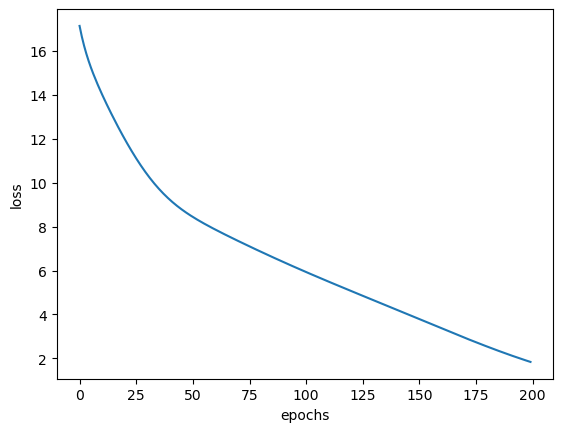

In [58]:
# plot the loss
plt.plot(losses)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

After training, we provide the first image of the original 2 sequences, and let the model to recover the full sequences for us.

In [59]:
# a trainer that only updates the hidden nodes
pc_tester = pc.PCTrainer(
    model, 
    T=100,
    update_x_at='all',
    optimizer_x_fn=optim.SGD,
    optimizer_x_kwargs={"lr": 1e-2},
    update_p_at='never',
    plot_progress_at=[],
)

# we set the initial recall to be the ground truth, and infer the first hidden state from it
recalls = torch.zeros(options.seq_len, options.batch_size, 784).to(device)
recalls[0] = data[0]
pc_tester.train_on_batch(
    inputs=(hidden_init, 0),
    loss_fn=loss_fn,
    loss_fn_kwargs={"_target": data[0]},
    is_log_progress=False,
    is_return_results_every_t=False,
)

model.eval() # so pc layer outputs mu directly

# Recall the rest of the sequence by a fast forward pass
# model[0]: the recurrent part, with Wr and Win
# model[1]: the decoder
prev_hidden = model[0][1].get_x().detach().clone()
for k in range(1, options.seq_len):
    # the following two steps can also be done with a 'forward' function if you decide to wrap the model into a class
    hidden = model[0]((prev_hidden, 0)).detach().clone()
    recalls[k] = model[1](hidden)
    prev_hidden = hidden


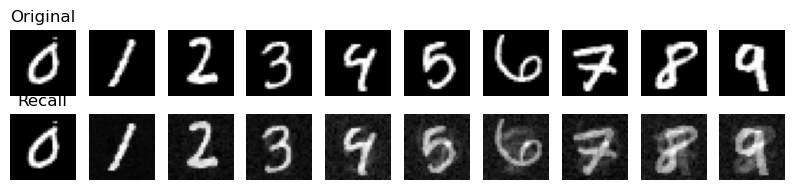

In [63]:
# visualize the original sequences and recalls
fig, axs = plt.subplots(2, options.seq_len, figsize=(10, 2))
for i in range(options.seq_len):
    axs[0, i].imshow(data[i].reshape(28, 28).cpu().numpy(), cmap='gray')
    axs[1, i].imshow(recalls[i].reshape(28, 28).detach().cpu().numpy(), cmap='gray')

for ax in axs.flatten():
    ax.axis('off')

axs[0, 0].set_title('Original')
axs[1, 0].set_title('Recall')

plt.show()

You can train this model longer to get better recall results, as the loss curve suggests the model hasn't converged yet.